In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import os
import datetime as dt
import numpy as np
from copy import deepcopy
import seaborn as sns
from IPython.display import display
from scipy.stats import linregress

import geoplot 
import geopandas as gpd


In [2]:
#Dataset to get geographical location information 
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Load

In [3]:
files = os.listdir("data")
# Sort dates
dates = [dt.datetime.strptime(re.findall(r'\d{4}-\d{2}-\d{2}',f)[0],'%Y-%m-%d') for f in files]
dates = sorted(dates,reverse=False)
dates = [i.strftime('%Y-%m-%d') for i in dates]

dfs_raw = {d: pd.read_csv(f'data/worldometers-{d}.tsv',sep="\t") for d in dates}

# Preprocess

In [4]:
dfs = deepcopy(dfs_raw)
for df in dfs.values():
    for i in range(1, df.shape[1] - 1):
        # Fill nan in numerical data with 0
        df.iloc[:,i] = df.iloc[:,i].fillna(0)
    # Fill categorical nan with Other
    df.iloc[:,-1] = df.iloc[:,-1].fillna('Other')
    df.iloc[:,0] = df.iloc[:,0].fillna('Other')    

---

## What is the proportion of total deaths by total recovered ?

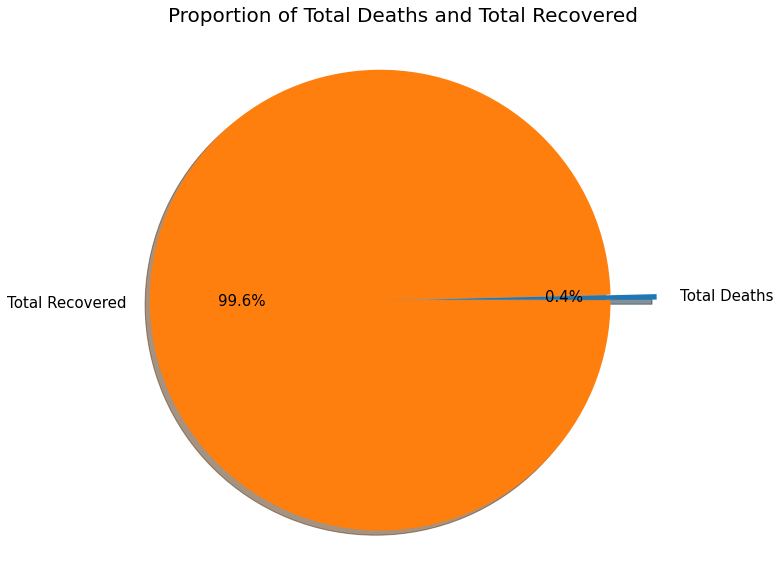

In [5]:
#Iterate over all dates and find the total deaths and total recovered 
day_deaths = np.fromiter([dfs[i]['NewDeaths'].sum() for i in dates],dtype= int)
day_recovered = np.fromiter([dfs[i]['NewRecovered'].sum() for i in dates],dtype= int)
deaths_recovered = [day_deaths.sum(),day_recovered.sum()]

#Plot pie chart to show the proportion between total deaths and total recovered
fig,ax = plt.subplots(figsize=(10,10)) 
ax.pie(deaths_recovered,
        explode=  (0.1,0.1),
        labels=['Total Deaths','Total Recovered'],
        autopct="%1.1f%%",
        startangle=0 ,
        shadow=True,
        textprops={'fontsize':15})
ax.axis('equal')
ax.set_title('Proportion of Total Deaths and Total Recovered',size=20)
plt.show() 

## What is the trend of Deaths and Recovered ?

/tmp/ipykernel_9976/309762900.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(dates,rotation= 50,fontsize=13)
/tmp/ipykernel_9976/309762900.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(dates,rotation= 50,fontsize=13)


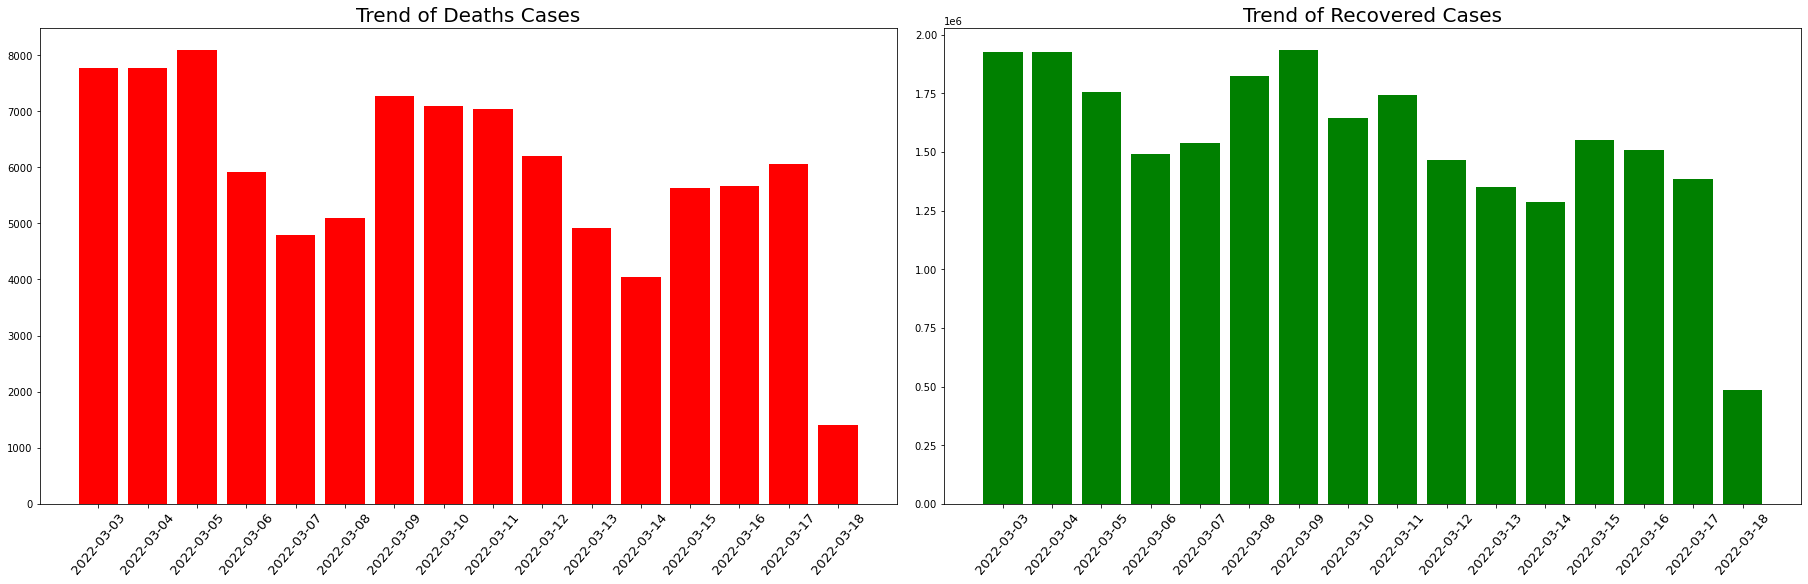

In [6]:
#Histogram to show the trend 
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(25,8),constrained_layout= True)
ax1.bar(dates,day_deaths,color='r')
ax1.set_xticklabels(dates,rotation= 50,fontsize=13)
ax1.set_title('Trend of Deaths Cases',size = 20)
ax2.bar(dates,day_recovered,color='g')
ax2.set_xticklabels(dates,rotation= 50,fontsize=13)
ax2.set_title('Trend of Recovered Cases',size= 20)
plt.show()

## What is the relationship between Total Deaths and Total Recovered 

<Figure size 1080x1440 with 0 Axes>

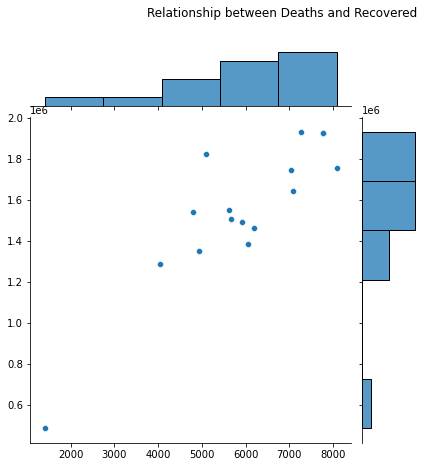

In [7]:
#Plot jointplot to show both the relationship and its distribution
plt.figure(figsize=(15,20))
sns.jointplot(x=day_deaths,y=day_recovered)
plt.title('Relationship between Deaths and Recovered',pad = 100,loc='Right')
plt.show()

# What is the Total Deaths and Total Recovered situation in each continent?

In [8]:
#Find total deaths and total recovered grouped by continent
continents_deaths = dfs[dates[-1]][['Continent','TotalDeaths']].groupby(by=['Continent']).sum()
continents_recovered = dfs[dates[-1]][['Continent','TotalRecovered']].groupby(by='Continent').sum()
new_index = {"Africa":"Africa","Asia":"Asia","Australia/Oceania":"Oceania","Europe":"Europe",
            "North America":"North America",
            "Other":"Antarctica",
            "South America":"South America"
}

#Rename continent to match the format of geoplot 
continents_deaths.rename(index=new_index,inplace=True)
continents_recovered.rename(index=new_index,inplace=True)
#Reset index 
continents_deaths = continents_deaths.reset_index(level= 0)
continents_recovered = continents_recovered.reset_index(level= 0)

In [9]:
#Join data with geographical information to show on the map 
#For total deaths
map_contients_deaths = pd.merge(world,continents_deaths,left_on='continent',right_on = 'Continent')
map_contients_deaths = map_contients_deaths.dissolve(by='continent',aggfunc='mean')
map_contients_deaths.reset_index(level=0,inplace= True)
#For total recovered
map_contients_recovered = pd.merge(world,continents_recovered,left_on='continent',right_on = 'Continent')
map_contients_recovered = map_contients_recovered.dissolve(by='continent',aggfunc='mean')
map_contients_recovered.reset_index(level=0,inplace= True)

/home/mag/miniconda3/envs/min_ds-env/lib/python3.8/site-packages/geoplot/geoplot.py:982: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


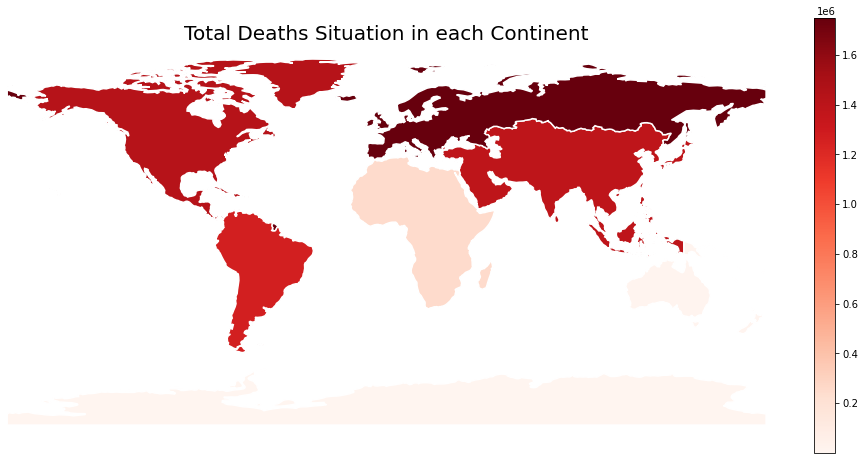

In [10]:
#Choropleht for total deaths in each continent
geoplot.choropleth(map_contients_deaths,
                    hue='TotalDeaths',
                    cmap="Reds",
                    figsize=(17,8),
                    edgecolor='white',
                    linewidth=1.5,
                    legend=True)
plt.title('Total Deaths Situation in each Continent',size=20)
plt.show()

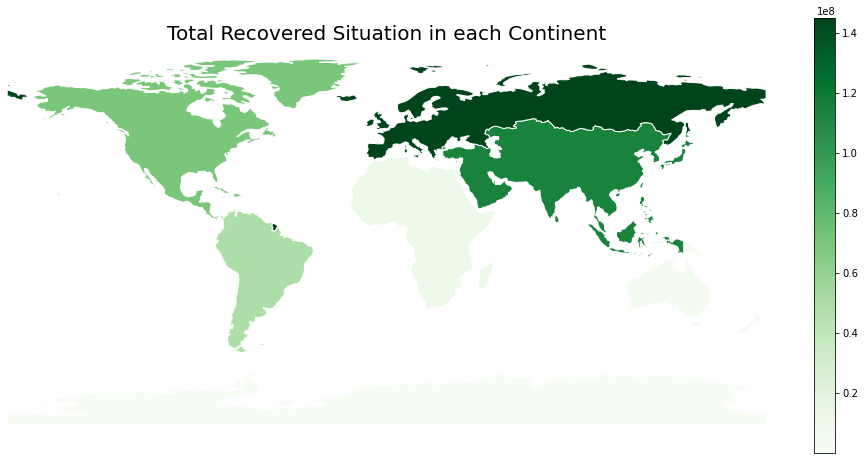

In [11]:
#Choropleth for total recovered in each continent
geoplot.choropleth(map_contients_recovered,
                    hue='TotalRecovered',
                    cmap="Greens",
                    figsize=(17,8),
                    edgecolor='white',
                    legend=True)
plt.title('Total Recovered Situation in each Continent',size=20)
plt.show()


---

# World Active Cases and Serious Cases Trend

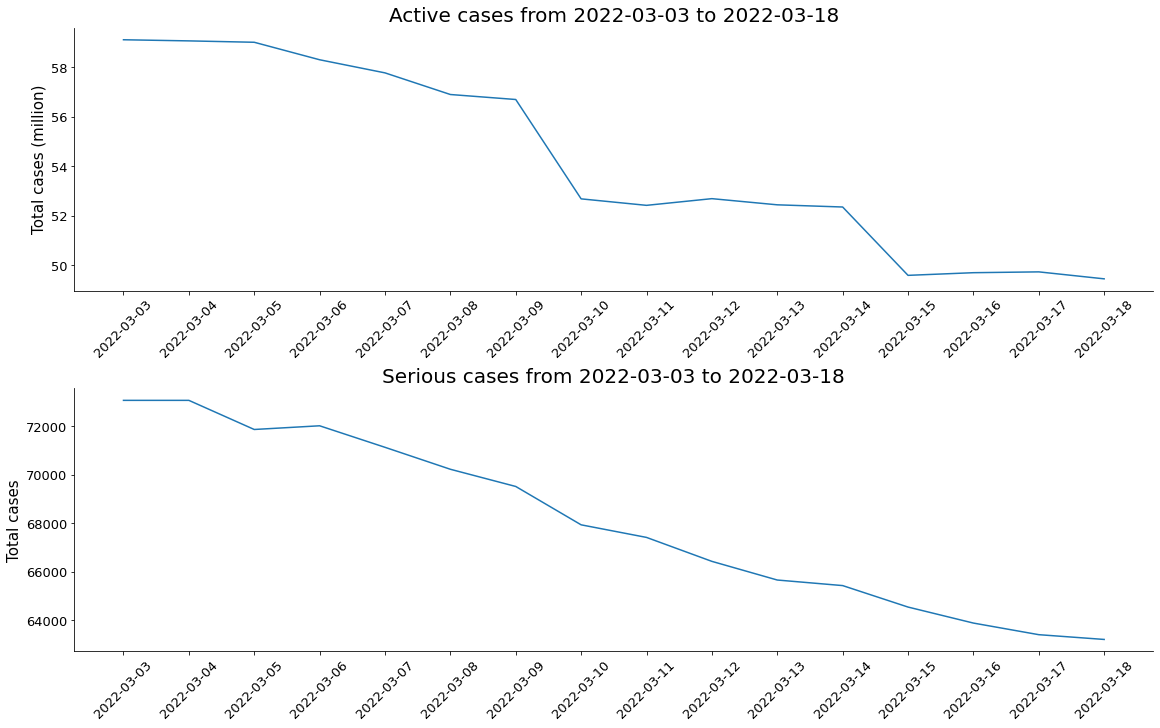

In [12]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,10),constrained_layout = True)

ax1.tick_params(axis='x', labelrotation=45)
ax1.ticklabel_format(style='plain') # remove scientific notation for ticks label
ax1.spines[['right','top']].set_visible(False) # remove redundancies to improve focus
ax1.set_title(f"Active cases from {dates[0]} to {dates[-1]}",fontsize=20)

t = np.fromiter([dfs[d]['ActiveCases'].sum() for d in dates],dtype=int)
ax1.plot(dates, t/10**6) # normalize data so as to remove confusion
ax1.tick_params(labelsize=13)
ax1.set_ylabel('Total cases (million)',fontsize=15)

ax2.tick_params(axis='x', labelrotation=45)
ax2.ticklabel_format(style='plain') # remove scientific notation for ticks label
ax2.spines[['right','top']].set_visible(False) # remove redundancies to improve focus
ax2.set_title(f"Serious cases from {dates[0]} to {dates[-1]}", fontsize=20)
ax2.plot(dates, [dfs[d]['Serious,Critical'].sum() for d in dates])
ax2.tick_params(labelsize=13)
ax2.set_ylabel('Total cases',fontsize=15)

# Save figures
fig.savefig("figures/Active-Serious-Trend")

# Continents' active, serious cases latest date

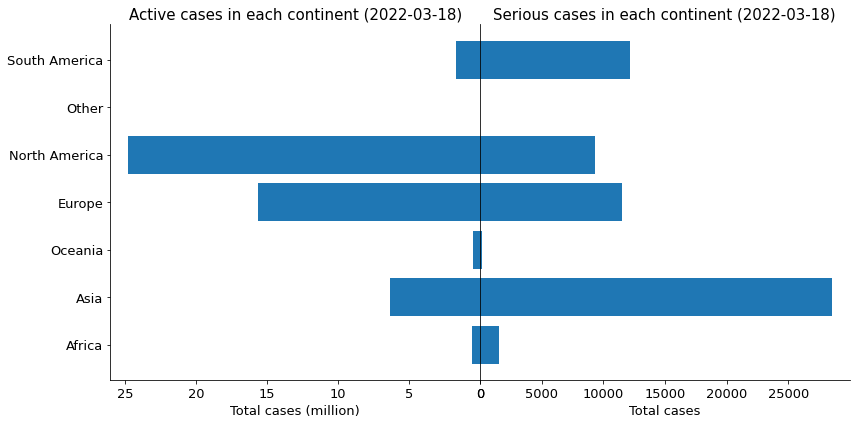

In [13]:
ActiveCasesContinent = dfs[dates[-1]][['Continent','ActiveCases']].groupby(by='Continent').agg(['sum'])
SeriousCasesContinent = dfs[dates[-1]][['Continent','Serious,Critical']].groupby(by='Continent').agg(['sum'])
x_labels = ['Africa','Asia', 'Oceania', 'Europe', 'North America', 'Other', 'South America']

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))
fig.tight_layout()

t = np.round(ActiveCasesContinent.values.reshape((1, -1))[0]/10**6,2)
bars = ax1.barh(x_labels, t)
ax1.invert_xaxis()
ax1.spines['top'].set_visible(False) # remove redundancies to improve focus
ax1.ticklabel_format(axis='x', style='plain') # remove scientific notation for ticks label
ax1.set_title(f"Active cases in each continent ({dates[-1]})",fontsize=15)
ax1.tick_params(labelsize=13)
ax1.set_xlabel('Total cases (million)',fontsize=13)

t = SeriousCasesContinent.values.reshape((1, -1))[0]
bars = ax2.barh(x_labels, t)
ax2.spines[['right','top']].set_visible(False)  # remove redundancies to improve focus
ax2.ticklabel_format(axis='x', style='plain') # remove scientific notation for ticks label
ax2.set_title(f"Serious cases in each continent ({dates[-1]})",fontsize=15)
ax2.set_xlabel('Total cases',fontsize=13)
ax2.tick_params(labelsize=13)
ax2.tick_params(axis='y',labelleft=False, left=False)

fig.tight_layout()
fig.subplots_adjust(wspace=0)

# save figures
fig.savefig("figures/Active-Serious-Cont")

# Active cases and serious cases relationship

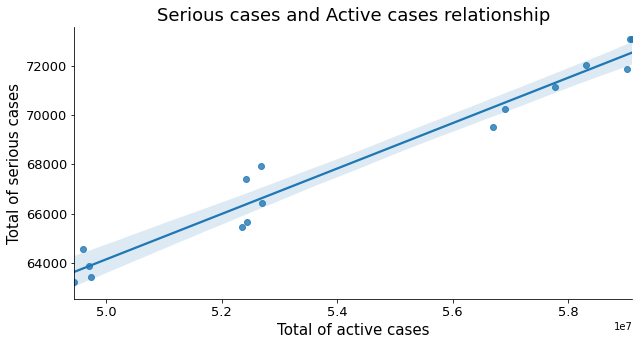

In [14]:
# Get world serious, active cases
SeriousCases = np.fromiter([dfs[d]['Serious,Critical'].sum() for d in dates],dtype=int)
ActiveCases = np.fromiter([dfs[d]['ActiveCases'].sum() for d in dates],dtype=int)

fig, ax = plt.subplots(1,1,figsize=(10,5))
# Each data point is the data of a date
sns.regplot(x=ActiveCases,y=SeriousCases, ax=ax)
ax.spines[['right','top']].set_visible(False)
ax.set_ylabel("Total of serious cases", fontsize=15)
ax.set_xlabel("Total of active cases", fontsize=15)
ax.set_title("Serious cases and Active cases relationship", fontsize=18)
ax.tick_params(labelsize=13)

# Save figures
fig.savefig("figures/Active-Serious-Rel")

---

### Total cases ~ Active cases

In [15]:
dfs0 = dfs[dates[0]]

### Total cases

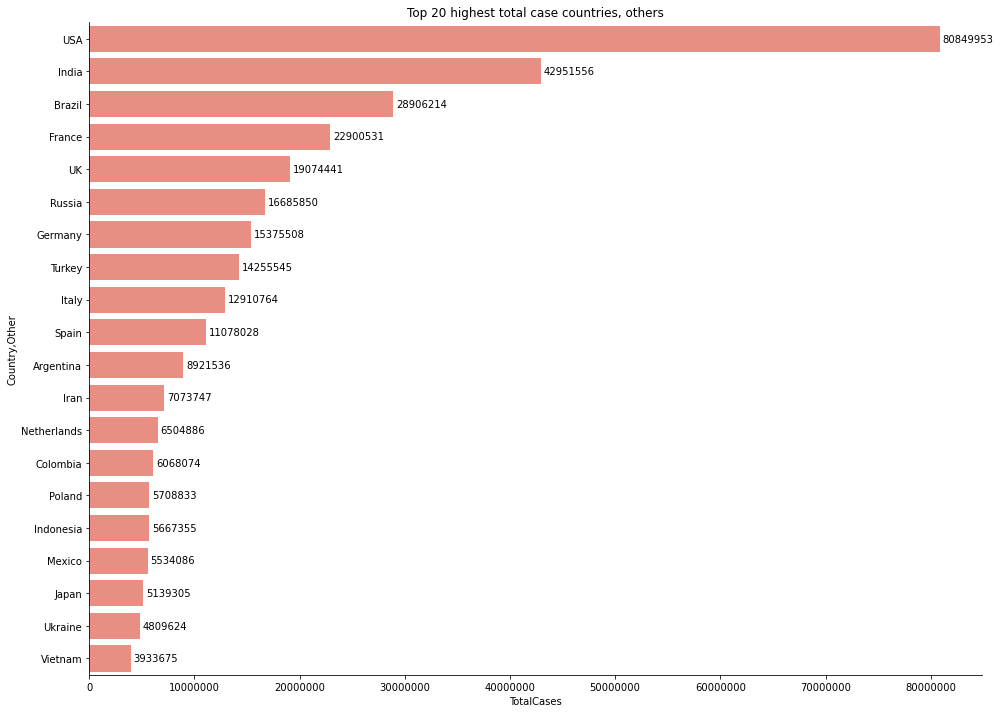

In [16]:
plt.figure(figsize= (16,12))
ax = sns.barplot(data=dfs0.head(20), x='TotalCases', y='Country,Other', color='salmon')
plt.bar_label(ax.containers[0], fmt='%d', padding=3)
ax.spines[['right','top']].set_visible(False)
plt.ticklabel_format(style='plain', axis='x') # remove scientific notation for ticks label
plt.title('Top 20 highest total case countries, others')
plt.show()

### Active cases

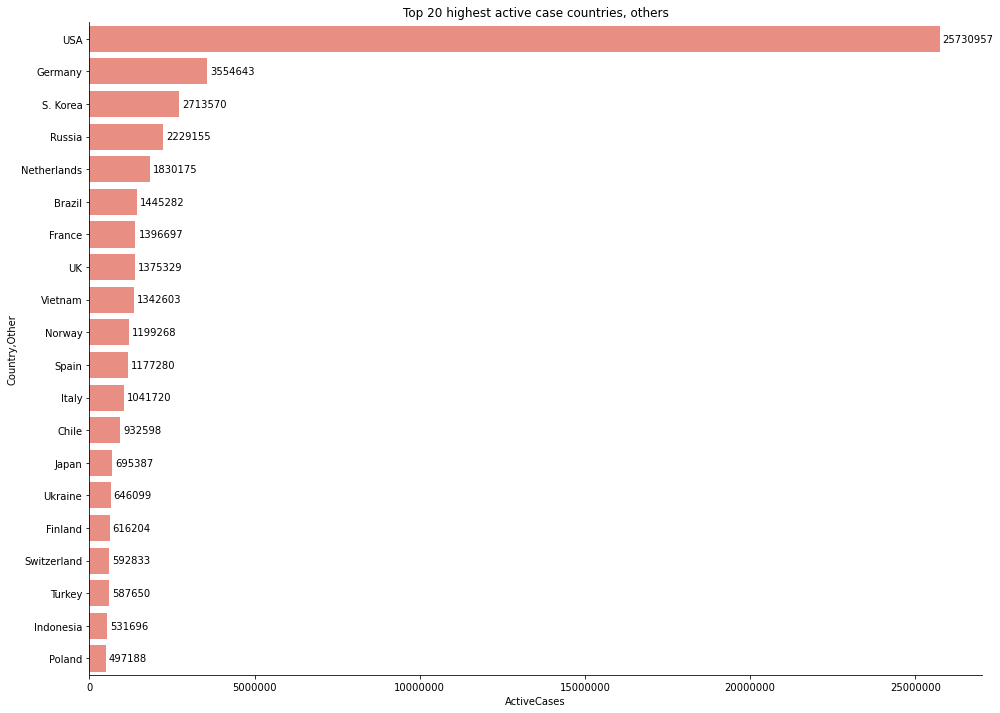

In [17]:
plt.figure(figsize= (16,12))
ax = sns.barplot(data=dfs0.nlargest(n=20, columns=['ActiveCases']), x='ActiveCases', y='Country,Other', color='salmon')
plt.bar_label(ax.containers[0], fmt='%d', padding=3)
ax.spines[['right','top']].set_visible(False)
plt.ticklabel_format(style='plain', axis='x') # remove scientific notation for ticks label
plt.title('Top 20 highest active case countries, others')
plt.show()

In [18]:
# calculate active and total case by each continent
active_cases_contient_df = dfs0.groupby('Continent')['ActiveCases'].sum().reset_index()
total_cases_contient_df = dfs0.groupby('Continent')['TotalCases'].sum().reset_index()

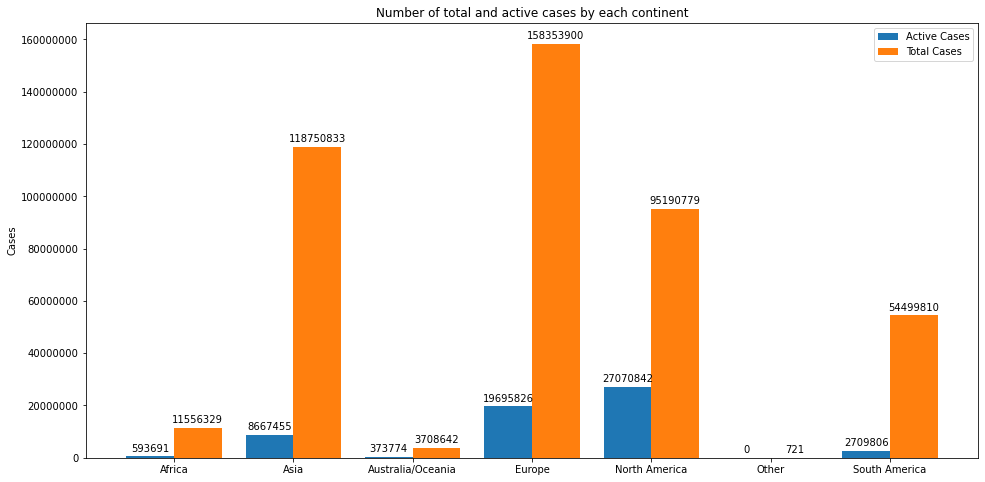

In [19]:
fig, ax = plt.subplots(figsize=(16,8))
labels = active_cases_contient_df['Continent']
x = np.arange(len(labels))
rects1 = ax.bar(x - 0.2, active_cases_contient_df['ActiveCases'], width=0.4, label='Active Cases')
rects2 = ax.bar(x + 0.2, total_cases_contient_df['TotalCases'], width=0.4, label='Total Cases')

# add number for each bar
ax.bar_label(rects1, fmt='%d', padding=3)
ax.bar_label(rects2, fmt='%d', padding=3)
ax.set_ylabel('Cases')
ax.set_title('Number of total and active cases by each continent')
plt.xticks(x, labels)
ax.ticklabel_format(style='plain', axis='y') # remove scientific notation for ticks label
ax.legend()
plt.show()

### Is there a relationship between them?

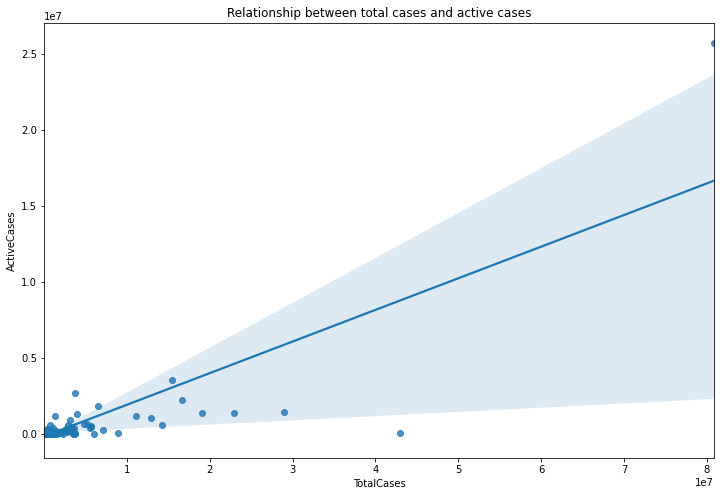

In [20]:
plt.figure(figsize=(12,8))
sns.regplot(data=dfs0, x='TotalCases', y='ActiveCases')
plt.title('Relationship between total cases and active cases')
plt.show()

### This time we mark the color for each point based on their contient


<Figure size 1152x864 with 0 Axes>

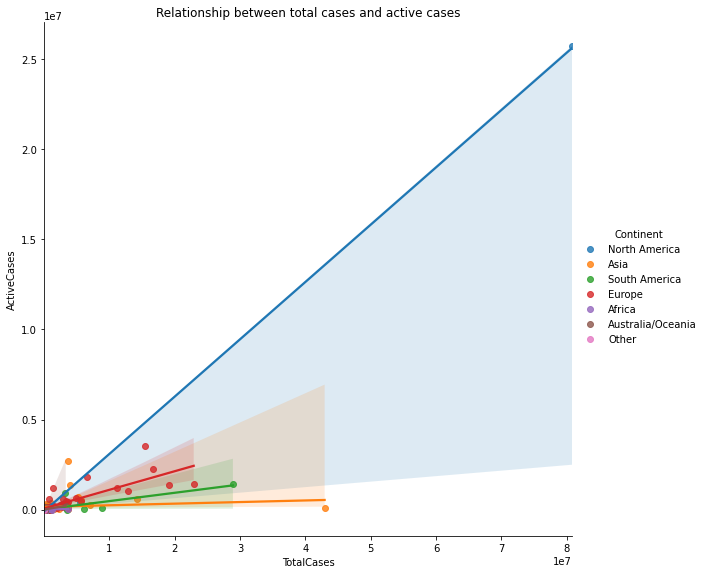

In [21]:
plt.figure(figsize=(16,12))
# serperate by Continent
sns.lmplot(data=dfs0, x='TotalCases', y='ActiveCases', hue='Continent', height=8)
plt.title('Relationship between total cases and active cases')
plt.show()

---

# Top 10 Highest Total tests to Population ratio

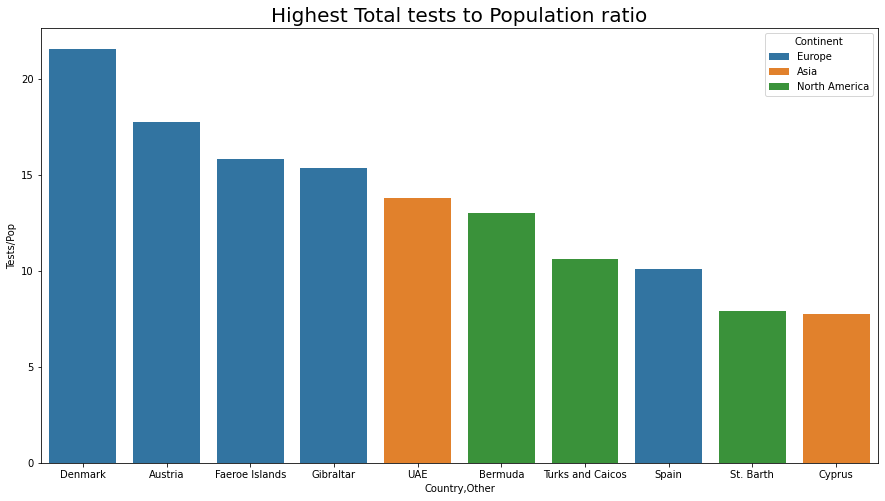

In [22]:
plt.figure(figsize=(15, 8))
data = deepcopy(dfs['2022-03-03'])
data['Tests/Pop'] = data['TotalTests'] / data['Population']
data = data.sort_values(by='Tests/Pop',ascending = False)
topten = data.head(10)
sns.barplot(x = topten['Country,Other'], y = topten['Tests/Pop'], hue=topten['Continent'],dodge=False)
plt.title('Highest Total tests to Population ratio',fontsize = 20)
plt.show()

# Population of the top 10 highest Tests/Population

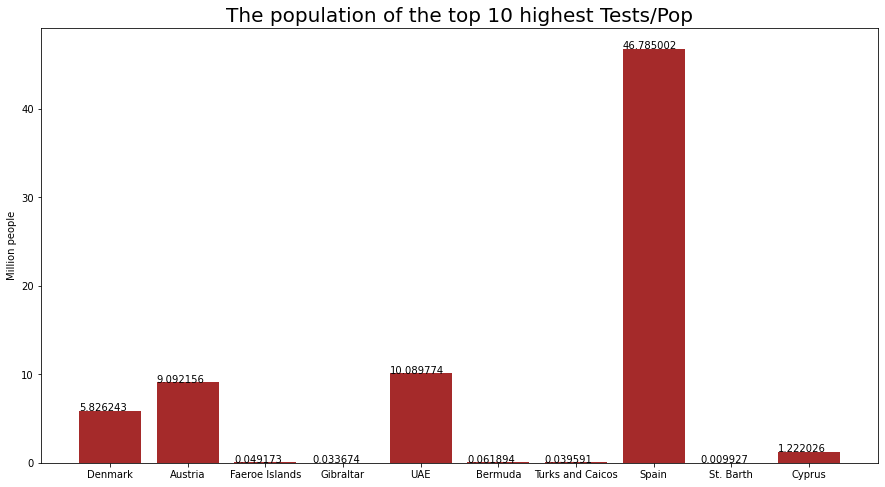

In [23]:
plt.figure(figsize=(15, 8))
bars = plt.bar(x = topten['Country,Other'], height = topten['Population']/10**6,color = 'brown')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(),yval+0.0005, yval)
plt.ylabel("Million people")
plt.title('The population of the top 10 highest Tests/Pop',fontsize = 20)
plt.show()

# Relationship between Cases and Tests

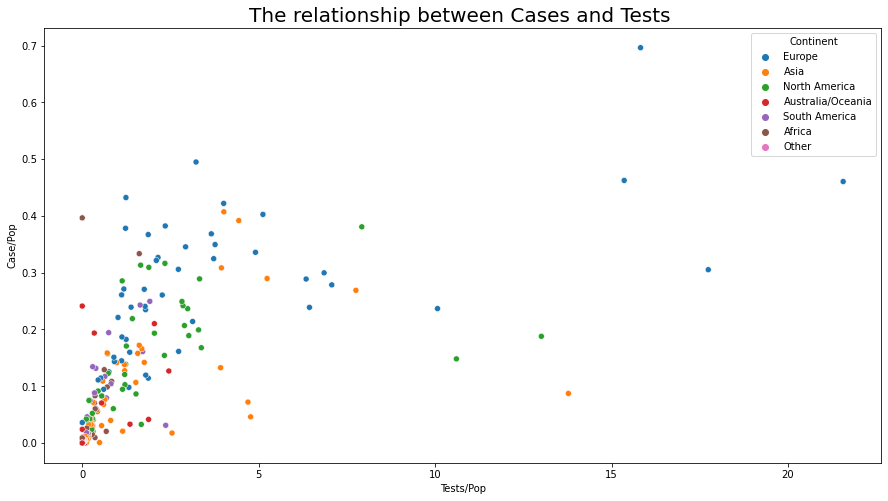

In [24]:
plt.figure(figsize=(15, 8))
data['Case/Pop'] = data['TotalCases'] / data['Population']
sns.scatterplot(x = data["Tests/Pop"], y = data["Case/Pop"], hue = data['Continent'])
plt.title("The relationship between Cases and Tests ", fontsize = 20)
plt.show()